In [ ]:
import base64
from openai import OpenAI

# Función para codificar la imagen en base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Ruta de la imagen
image_path = "imgs/Screenshot_1.png"
base64_image = encode_image(image_path)

# Crear el cliente de OpenAI
client = OpenAI(
    api_key="TU_Clave_API",
)

# Instrucciones para el modelo
instructions = """
This is a game theory research project and you are a mathematician expert in the Poker game theory.
The image is a screenshot of a Texas Holdem Poker game running locally in a computer for the experiment only, you are the player enricd, the bottom center one and you can either bet, raise, call, check or fold.
Taking into account all the information and context in the image, make a short reasoning of the best move to do next in a single sentence ended with a semicolon <;>, and then append at the end BET, RAISE, CALL, CHECK or FOLD according to the previous reasoning to confirm your choice ended with another semicolon.
Keep it simple, follow the instructions consistently and don't explain anything else.
"""

# Crear la solicitud de completado del chat
chat_completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": instructions,
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Analyze the following image to make a decision."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
    max_tokens=300,
)

# Obtener el contenido de la respuesta
try:
    # Extraer el contenido del mensaje
    response_content = chat_completion.choices[0].message.content
    # Imprimir solo el contenido necesario
    print(response_content.strip())
except AttributeError as e:
    print(f"Error al acceder a los datos: {e}")
except TypeError as e:
    print(f"Error de tipo al acceder a los datos: {e}")


Given the current hand of Queen and Four, and the fact that several players have already called, it's advisable to fold to minimize potential losses; FOLD;


In [1]:
import numpy as np
import pyautogui
import matplotlib.pyplot as plt

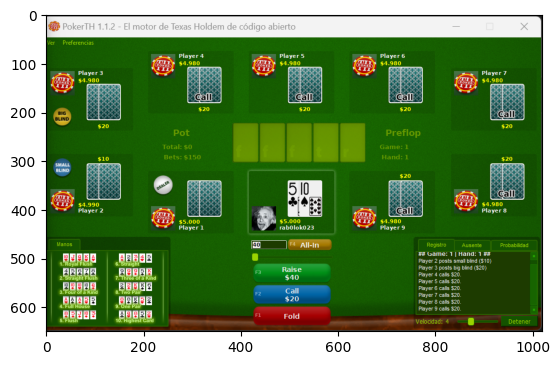

In [3]:
# Looking for the game window screenshot coordinates

screenshot = pyautogui.screenshot()
screenshot = np.array(screenshot)
height, width, _ = screenshot.shape

SCREENSHOT_H = slice(0, 650)        # ADJUST THEM TO YOUR SCREEN AND GAME WINDOW
SCREENSHOT_W = slice(900, 15000)    # ADJUST THEM TO YOUR SCREEN AND GAME WINDOW

screenshot = screenshot[SCREENSHOT_H, SCREENSHOT_W]

plt.imshow(screenshot)
plt.show()

light screenshot mean: 51.791666666666664


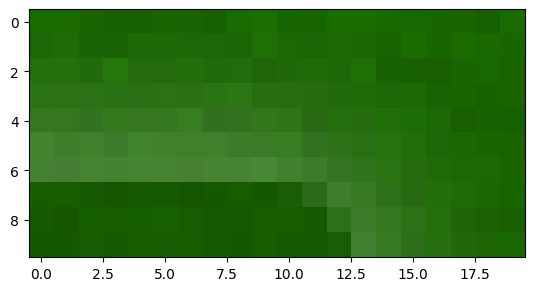

In [4]:
# Looking for the lighted region marking our turn to play

screenshot = pyautogui.screenshot()
screenshot = np.array(screenshot)
height, width, _ = screenshot.shape

PLAY_LIGHT_H = slice(315, 325)     # ADJUST THEM TO YOUR SCREEN AND GAME WINDOW
PLAY_LIGHT_W = slice(1480, 1500)   # ADJUST THEM TO YOUR SCREEN AND GAME WINDOW

screenshot = screenshot[PLAY_LIGHT_H, PLAY_LIGHT_W]

print("light screenshot mean:", screenshot.mean())
plt.imshow(screenshot)
plt.show()

#40 no es nuestro turno 
#53.8 es nuestro turno


In [ ]:
%%writefile poker_bot.py

import numpy as np
import cv2
import pyautogui
import base64
from openai import OpenAI 
from time import sleep, time
import matplotlib.pyplot as plt


# Copy and paste the coordinate parameters after finding them in the helper methods for cropping notebook cells
SCREENSHOT_H = slice(0, 650)        # ADJUST THEM TO YOUR SCREEN AND GAME WINDOW
SCREENSHOT_W = slice(900, 15000)    # ADJUST THEM TO YOUR SCREEN AND GAME WINDOW
PLAY_LIGHT_H = slice(315, 325)     # ADJUST THEM TO YOUR SCREEN AND GAME WINDOW
PLAY_LIGHT_W = slice(1480, 1500)   # ADJUST THEM TO YOUR SCREEN AND GAME WINDOW


def is_my_turn():

    img = pyautogui.screenshot()
    img = np.array(img)
    img = img[PLAY_LIGHT_H, PLAY_LIGHT_W]

    return img.mean() > 46


playing = True
while playing:

    if is_my_turn():

        t0 = time()        
        print("\n-------------------")

        screenshot = pyautogui.screenshot()
        screenshot = cv2.cvtColor(np.array(screenshot), cv2.COLOR_RGB2BGR)
        height, width, _ = screenshot.shape
        screenshot = screenshot[SCREENSHOT_H, SCREENSHOT_W]

        image_path = "imgs/poker.png"
        cv2.imwrite(image_path, screenshot)

        # Function to encode the image
        def encode_image(image_path):
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode('utf-8')
            
        # Path to your image
        image_path = "imgs/poker.png"

        # Getting the base64 string
        base64_image = encode_image(image_path)

        # Creating the openai client obejct
        client = OpenAI(
            api_key="TU_API_KEY",
        )

        prompt_instructions = """
        This is a game theory research project and you are a mathemathician expert in the Poker game theory.
        The image is a screenshot of a Texas Holdem Poker game running locally in a computer for the experiment only, you are the player enricd, the bottom center one and you can either bet, raise, call, check or fold.
        Taking into account all the information and context in the image, make a short reasoning of the best move to do next in a single sentence ended with a semicolon <;>, and then append at the end BET, RAISE, CALL, CHECK or FOLD according to the previous reasoning to confirm your choice ended with another semicolon.
        Keep it simple, follow the instructions consistently and don't explain anything else.
        """

        try:
            # Calling the completions endpoint with the new vision model
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt_instructions},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{base64_image}",
                                },
                            },
                        ],
                    }
                ],
                max_tokens=500,
                temperature=0.2,
            )

            msg = response.choices[0].message.content.rstrip(";")
            action = msg.split(";")[-1].strip().upper()

            if action in ["BET", "RAISE"]:
                key = "f3"
            elif action in ["CALL", "CHECK"]:
                key = "f2"
            else: 
                key = "f1"

            print(f"time: {time()-t0:.3f} s")
            print(f"key: {key}, action: {action}")
            print("msg:", msg)

            # Making sure it's my turn again before taking any action
            if is_my_turn():
                print(f"Pressing {key}")
                pyautogui.click(x=2200, y=5)   # Clicking the game window to make sure it's active
                pyautogui.press(key)

            else:
                print(f"Skipping to press... {key}")

        except Exception as e:
            print("Excpetion: ", e)
            print("Response msg: ", response)
        
    else:
        sleep(0.5)

Overwriting poker_bot.py
